## Data loading

In [ ]:
import pyarrow.parquet as pq
import pandas as pd

# Read the Parquet file containing human protein abundance, PPI, and sequence embeddings

file_path = 'data/h_sapiens_abundance_PPI_seq_embeddings.parquet'
parquet_file = pq.ParquetFile(file_path)

# Loop through each row group
dfs = []

for i in range(parquet_file.num_row_groups):
    print(f"Reading row group {i+1} of {parquet_file.num_row_groups}...")
    table = parquet_file.read_row_group(i)
    df = table.to_pandas()
    dfs.append(df)

# Concatenate all row groups
full_df = pd.concat(dfs, ignore_index=True)


Reading row group 1 of 2...
Reading row group 2 of 2...


In [ ]:
# Read the Parquet file containing mouse protein abundance, PPI, and sequence embeddings

file_path_mouse = 'data/m_musculus_abundance_PPI_seq_embeddings.parquet'
parquet_file_mouse = pq.ParquetFile(file_path_mouse)

# Loop through each row group
dfs_mouse = []

for i in range(parquet_file_mouse.num_row_groups):
    print(f"Reading row group {i+1} of {parquet_file_mouse.num_row_groups}...")
    table = parquet_file_mouse.read_row_group(i)
    df_mouse = table.to_pandas()
    dfs_mouse.append(df_mouse)

# Concatenate all row groups
full_df_mouse = pd.concat(dfs_mouse, ignore_index=True)


Reading row group 1 of 1...


In [6]:
df.columns

Index(['dataset_id', 'dataset_name', 'dataset_description', 'organism_id',
       'organism_name', 'sample_organ', 'is_integrated', 'quality_score',
       'coverage', 'publication_link', 'publication_year', 'original_filename',
       'string_external_id', 'EnsemblProteinID', 'mapped_from',
       'UniprotEntryName', 'UniprotAccession', 'ProteinName', 'GeneSymbol',
       'Sequence', 'uniprot_status', 'nog_id', 'abundance',
       'EnsemblTranscript', 'EnsemblGene', 'PPI_embeddings',
       'sequence_embeddings'],
      dtype='object')

In [ ]:
target_organ = 'LIVER'  # Change to KIDNEY later

## Human data cleanup for training

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Filter to integrated human data
df = full_df.copy()
df = df[df['is_integrated'] == True]
df = df[df['organism_name'] == 'H.sapiens']

# Pivot table so that rows are proteins, columns are organs, values are abundance
abund_matrix = df.pivot_table(
    index='string_external_id',
    columns='sample_organ',
    values='abundance',
    aggfunc='mean'  # In case of multiple entries
)

In [ ]:


#  Filter abundance features to common organs
common_organs = {
    'BRAIN', 'CEREBRAL_CORTEX', 'HEART', 'LIVER', 'LUNG',
    'PANCREAS', 'PLASMA', 'PLATELET', 'SPLEEN', 'WHOLE_ORGANISM'
}
X_abund = abund_matrix.loc[:, abund_matrix.columns.intersection(common_organs)]
display(X_abund.head())


sample_organ,BRAIN,CEREBRAL_CORTEX,HEART,LIVER,LUNG,PANCREAS,PLASMA,PLATELET,SPLEEN,WHOLE_ORGANISM
string_external_id,,,,,,,,,,
9606.ENSP00000000233,289.00,162.0,155.0,239.000,288.00,165.0,2.420,731.0,148.0,175.000
9606.ENSP00000000412,20.00,121.0,21.8,76.500,66.70,39.3,0.498,147.0,128.0,58.100
9606.ENSP00000001008,119.00,405.0,180.0,203.000,188.00,250.0,1.420,39.3,212.0,289.000
9606.ENSP00000001146,NaN,NaN,NaN,0.056,NaN,NaN,NaN,NaN,NaN,0.002
9606.ENSP00000002125,2.81,30.3,36.3,8.050,7.77,12.2,NaN,NaN,16.7,8.190


In [122]:
y = X_abund[target_organ]
X_abund_features = X_abund.drop(columns=target_organ)

X_abund_fillna0 = X_abund_features.fillna(0)

# Version 2: Impute with protein-wise mean (row-wise)
X_abund_imputed = X_abund_features.T.fillna(X_abund_features.mean(axis=1)).T


In [ ]:
# Unpack embeddings into columns
def unpack_embedding_column(df, column_name, prefix):
    emb_df = pd.DataFrame(df[column_name].tolist(), index=df.index)
    emb_df.columns = [f"{prefix}_{i}" for i in range(emb_df.shape[1])]
    return emb_df

# Drop duplicates to keep one row per protein
embedding_df = df.drop_duplicates(subset='string_external_id').set_index('string_external_id')

# Unpack PPI and sequence embeddings
ppi_df = unpack_embedding_column(embedding_df, 'PPI_embeddings', 'ppi')
seq_df = unpack_embedding_column(embedding_df, 'sequence_embeddings', 'seq')

#  Filter to proteins with full data
# common_proteins = X_abund.index.intersection(ppi_df.index).intersection(seq_df.index)
#X_abund = X_abund.loc[common_proteins]
#X_ppi = ppi_df.loc[common_proteins]
#X_seq = seq_df.loc[common_proteins]
X_ppi = ppi_df
X_seq = seq_df

display(X_ppi.head())

/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ppi_0,ppi_1,ppi_2,ppi_3,ppi_4,ppi_5,ppi_6,ppi_7,ppi_8,ppi_9,...,ppi_502,ppi_503,ppi_504,ppi_505,ppi_506,ppi_507,ppi_508,ppi_509,ppi_510,ppi_511
string_external_id,,,,,,,,,,,,,,,,,,,,,
9606.ENSP00000295897,0.015717,0.007851,0.010025,-0.010971,-0.017471,-0.017609,-0.031342,0.030243,-0.018875,0.018204,...,0.033081,0.013435,0.047791,0.009529,-0.034882,-0.016830,-0.035950,0.006821,-0.002024,0.001499
9606.ENSP00000322421,0.145996,-0.043945,-0.009079,0.030136,-0.021347,0.039185,0.018738,0.015915,-0.023727,0.041779,...,0.080139,0.024582,0.101807,-0.006630,0.043335,0.049622,-0.014961,0.009254,-0.000183,0.046967
9606.ENSP00000251595,0.154663,-0.021286,-0.016632,0.026978,-0.020416,0.019547,0.020828,0.032745,-0.006756,0.052368,...,0.038483,0.015961,0.115234,0.010010,0.045410,-0.009041,-0.036774,0.010849,0.009781,0.042328
9606.ENSP00000295834,0.004490,0.056061,0.049438,0.002422,-0.012749,-0.000353,-0.005341,0.035583,0.009819,0.018738,...,0.057800,0.001807,0.059448,-0.010666,-0.005173,0.133789,-0.028992,0.000950,-0.014160,-0.002712
9606.ENSP00000446007,0.040985,-0.022202,0.047546,-0.037292,-0.003492,-0.006283,-0.012733,0.036560,-0.017761,0.031921,...,0.000570,-0.002853,0.004410,0.001233,0.027237,0.010139,-0.039001,0.005810,-0.018387,0.011185


In [ ]:

# Combine all features and apply log transform
X = pd.concat([X_abund_fillna0, X_ppi, X_seq], axis=1)
# X = pd.concat([X_abund_imputed, X_ppi, X_seq], axis=1)

X_log = np.log1p(X)
y_log = np.log1p(y)
# Check and clean any inf or NaN values from log-transformed features
# Count NaNs
num_nan_X = X_log.isnull().sum().sum()
num_nan_y = y_log.isnull().sum()

# Count infs
num_inf_X = np.isinf(X_log.values).sum()
num_inf_y = np.isinf(y_log.values).sum()

print(f"Number of NaNs in X_log: {num_nan_X}")
print(f"Number of NaNs in y_log: {num_nan_y}")
print(f"Number of infs in X_log: {num_inf_X}")
print(f"Number of infs in y_log: {num_inf_y}")
X_log = X_log.replace([np.inf, -np.inf], np.nan).dropna()
y_log = y_log.loc[X_log.index]  # Make sure target matches cleaned features
# Remove NaNs/infs from y and re-align X
valid_y_mask = y_log.notna() & np.isfinite(y_log)
X_log = X_log.loc[valid_y_mask]
y_log = y_log.loc[valid_y_mask]

/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


Number of NaNs in X_log: 307
Number of NaNs in y_log: 3136
Number of infs in X_log: 14
Number of infs in y_log: 0


In [135]:
X

/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,BRAIN,CEREBRAL_CORTEX,HEART,LUNG,PANCREAS,PLASMA,PLATELET,SPLEEN,WHOLE_ORGANISM,ppi_0,...,seq_1014,seq_1015,seq_1016,seq_1017,seq_1018,seq_1019,seq_1020,seq_1021,seq_1022,seq_1023
string_external_id,,,,,,,,,,,,,,,,,,,,,
9606.ENSP00000000233,289.0000,162.000000,155.0000,288.000000,165.000000,2.420000,731.000000,148.000000,175.0000,-0.045654,...,-0.014626,0.003374,-0.076355,-0.064636,0.007587,-0.060913,-0.047333,-0.065186,0.044403,0.035095
9606.ENSP00000000412,20.0000,121.000000,21.8000,66.700000,39.300000,0.498000,147.000000,128.000000,58.1000,-0.002146,...,-0.038818,-0.030807,0.022812,-0.013000,-0.013428,-0.046906,-0.007217,-0.017868,0.023895,0.035339
9606.ENSP00000001008,119.0000,405.000000,180.0000,188.000000,250.000000,1.420000,39.300000,212.000000,289.0000,0.061035,...,-0.028702,0.003244,0.022491,-0.010551,0.020813,-0.039673,-0.057129,-0.052582,0.013931,0.018692
9606.ENSP00000001146,0.0020,0.002000,0.0020,0.002000,0.002000,0.002000,0.002000,0.002000,0.0020,-0.027298,...,0.015221,0.008232,0.039581,-0.022614,0.023911,-0.001366,-0.015182,-0.022415,-0.013977,0.008438
9606.ENSP00000002125,2.8100,30.300000,36.3000,7.770000,12.200000,16.324286,16.324286,16.700000,8.1900,-0.001792,...,-0.028915,-0.031128,0.020630,-0.040375,0.019928,-0.001399,-0.032806,-0.033905,0.013771,0.029785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606.ENSP00000485638,63.5000,39.200000,54.7000,35.700000,71.300000,3.540000,170.000000,27.200000,76.9000,-0.009300,...,0.041931,-0.026993,-0.090820,-0.077637,0.061798,-0.081421,-0.038818,-0.076721,0.086426,0.035828
9606.ENSP00000485656,0.0060,0.006000,0.0090,0.006000,0.006000,0.006000,0.006000,0.006000,0.0030,-0.004379,...,-0.072876,-0.012474,-0.032745,-0.020340,0.007809,-0.021103,0.005169,-0.031830,0.046204,0.078735
9606.ENSP00000485659,0.0630,9.270000,0.0070,40.300000,5.020000,0.002000,7.795250,6.100000,1.6000,0.005085,...,0.056976,0.026825,0.002731,-0.104187,0.146606,-0.094849,-0.084717,-0.010414,0.068909,0.038879


### XGBoost model


 Test MSE (log space): 0.4273
 Test R²: 0.8766
Spearman correlation: 0.8139


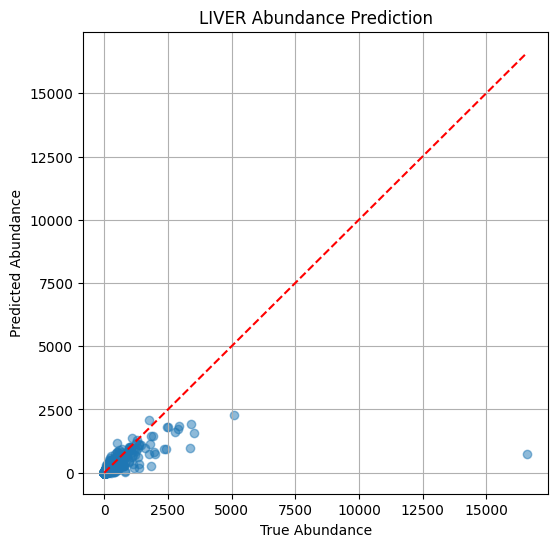

In [ ]:


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=42)


# Train XGBoost model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

from scipy.stats import spearmanr

# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"\n Test MSE (log space): {mse:.4f}")
print(f" Test R²: {r2:.4f}")

y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)
mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)
correlation, p_value = spearmanr(y_test_real, y_pred_real)

print(f"Spearman correlation: {correlation:.4f}")
# print(f"P-value: {p_value:.4e}")

# print(f"MSE (non-log space): {mse_real:.4f}")
# print(f"R² (non-log space): {r2_real:.4f}")


# Optional plot
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel('True Abundance')
plt.ylabel('Predicted Abundance')
plt.title(f'{target_organ} Abundance Prediction')
plt.grid(True)
plt.show()


In [98]:
import pandas as pd

# Get the booster object from your trained XGBoost model
booster = model.get_booster()

# Get feature importance scores (by 'gain')
importance_dict = booster.get_score(importance_type='total_gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'gain_importance': list(importance_dict.values())
})

# Sort descending
importance_df = importance_df.sort_values(by='gain_importance', ascending=False).reset_index(drop=True)

# Show top 30 features
top_n = 30
display(importance_df.head(top_n))


,feature,gain_importance
0,LUNG,156654.515625
1,PANCREAS,9174.810547
2,HEART,5251.825684
3,WHOLE_ORGANISM,3801.844971
4,ppi_37,1306.435059
5,ppi_272,1254.827148
6,ppi_336,846.261169
7,PLATELET,437.831787
8,ppi_79,368.224182
9,seq_538,343.108856


### Ridge regression


✅ Test MSE (log space): 0.4368
✅ Test R²: 0.8649


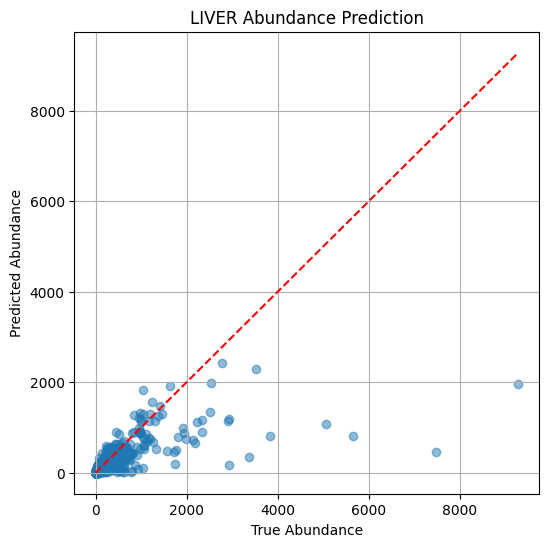

In [ ]:


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=42)

from sklearn.linear_model import RidgeCV

# Train
model_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
model_ridge.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Test MSE (log space): {mse:.4f}")
print(f"✅ Test R²: {r2:.4f}")

# Optional plot
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel('True Abundance')
plt.ylabel('Predicted Abundance')
plt.title(f'{target_organ} Abundance Prediction')
plt.grid(True)
plt.show()


### Lasso

/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.243e+00, tolerance: 3.025e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.845e+00, tolerance: 3.122e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of 


✅ Test MSE (log space): 0.4360
✅ Test R²: 0.8652


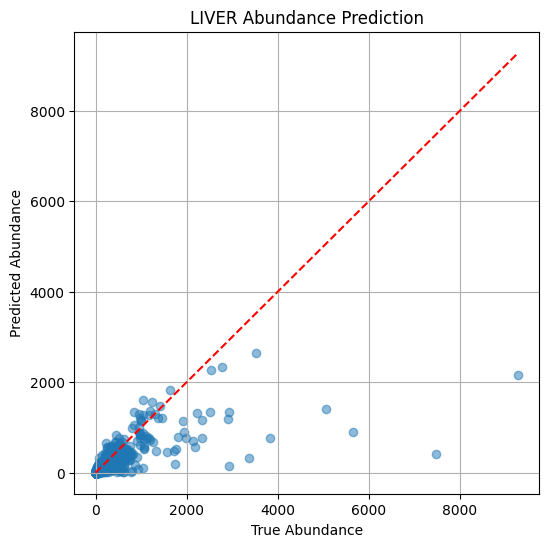

In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.3, random_state=42)

from sklearn.linear_model import LassoCV


# Train
model_lasso = LassoCV(
    alphas=np.logspace(-4, 1, 50),
    cv=5,
    max_iter=10000,
    random_state=42
)
model_lasso.fit(X_train, y_train)

#  Predict and evaluate
y_pred = model_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Test MSE (log space): {mse:.4f}")
print(f"✅ Test R²: {r2:.4f}")

# Optional plot
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel('True Abundance')
plt.ylabel('Predicted Abundance')
plt.title(f'{target_organ} Abundance Prediction')
plt.grid(True)
plt.show()


# Test the model on mouse data

## Loading mouse data

In [57]:
# Filter to integrated mouse data
df_mouse = full_df_mouse.copy()
df_mouse = df_mouse[df_mouse['is_integrated'] == True]

# Pivot: proteins as rows, organs as columns, abundance as values
abund_matrix_mouse = df_mouse.pivot_table(
    index='string_external_id',
    columns='sample_organ',
    values='abundance',
    aggfunc='mean'
).fillna(0)

# Restrict to common organs only (same as human model)
abund_matrix_mouse = abund_matrix_mouse.loc[:, abund_matrix_mouse.columns.intersection(common_organs)]


In [58]:
# Drop duplicates to map each protein to its embeddings
embedding_df_mouse = df_mouse.drop_duplicates(subset='string_external_id').set_index('string_external_id')

# Unpack PPI and sequence embeddings
ppi_mouse = unpack_embedding_column(embedding_df_mouse, 'PPI_embeddings', 'ppi')
seq_mouse = unpack_embedding_column(embedding_df_mouse, 'sequence_embeddings', 'seq')


In [93]:
# Only keep proteins that have all data (abundance + embeddings)
common_proteins_mouse = abund_matrix_mouse.index.intersection(ppi_mouse.index).intersection(seq_mouse.index)

X_abund_mouse = abund_matrix_mouse.loc[common_proteins_mouse]
X_ppi_mouse = ppi_mouse.loc[common_proteins_mouse]
X_seq_mouse = seq_mouse.loc[common_proteins_mouse]

y_mouse = X_abund_mouse[target_organ]
X_abund_filtered_mouse = X_abund_mouse.drop(columns=target_organ)



X_mouse = pd.concat([X_abund_filtered_mouse, X_ppi_mouse, X_seq_mouse], axis=1)
X_mouse_log = np.log1p(X_mouse)  # log-transform as done during training
# X_mouse_log = X_log.replace([np.inf, -np.inf], np.nan).dropna()

y_mouse_log = np.log1p(y_mouse)

# X_mouse_log = X_mouse_log.replace([np.inf, -np.inf], np.nan).dropna()
# y_mouse_log = y_mouse_log.loc[X_mouse_log.index]  # Make sure target matches cleaned features


/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)


## Predicting mouse data

### XGBoost evaluation on mouse data

In [137]:
# Predict
y_mouse_pred_log = model.predict(X_mouse_log)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr


mse_mouse = mean_squared_error(y_mouse_log, y_mouse_pred_log)
r2_mouse = r2_score(y_mouse_log, y_mouse_pred_log)

print(f"Mouse Test MSE: {mse_mouse:.4f}")
print(f"Mouse Test R²: {r2_mouse:.4f}")

y_mouse_real = np.expm1(y_mouse_log)
y_mouse_pred_real = np.expm1(y_mouse_pred_log)


mse_real = mean_squared_error(y_mouse_real, y_mouse_pred_real)
r2_real = r2_score(y_mouse_real, y_mouse_pred_real)


# print(f"MSE (non-log space): {mse_real:.4f}")
# print(f"R² (non-log space): {r2_real:.4f}")
correlation, p_value = spearmanr(y_mouse_real, y_mouse_pred_real)

print(f"Spearman correlation: {correlation:.4f}")
# print(f"P-value: {p_value:.4e}")


Mouse Test MSE: 1.0940
Mouse Test R²: 0.6654
Spearman correlation: 0.7425


### Ridge regression on mouse data

In [83]:
# Predict
y_mouse_pred_log = model_ridge.predict(X_mouse_log)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse_mouse = mean_squared_error(y_mouse_log, y_mouse_pred_log)
r2_mouse = r2_score(y_mouse_log, y_mouse_pred_log)

print(f"Mouse Test MSE: {mse_mouse:.4f}")
print(f"Mouse Test R²: {r2_mouse:.4f}")

Mouse Test MSE: 1.0817
Mouse Test R²: 0.6692


### Lasso on mouse data

In [85]:
# Predict
y_mouse_pred_log = model_lasso.predict(X_mouse_log)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse_mouse = mean_squared_error(y_mouse_log, y_mouse_pred_log)
r2_mouse = r2_score(y_mouse_log, y_mouse_pred_log)

print(f"Mouse Test MSE: {mse_mouse:.4f}")
print(f"Mouse Test R²: {r2_mouse:.4f}")

Mouse Test MSE: 7.7379
Mouse Test R²: -1.3663


/Users/martadujella/Code/DataProjects/PMDA/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
